## Getting started with infercnvpy for calling large scale copy number alterations (CNAs) from scRNAseq data
Purpose: To provide a foundational notebook for calling CNAs from scRNAseq data with infercnv. This notebook is largely based off the documentation and tutorial for infercnv provided at https://icbi-lab.github.io/infercnvpy/tutorials/tutorial_3k.html.
#### by: Emily Robitschek 

## Setup 
If you do not already have a conda environment for running infercnv analysis in jupyter notebooks, follow the instructions in the documentation

In [1]:
#imports
#tools for loading, manipulating and visualizing data
import pandas as pd
import numpy as np 
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from scipy import stats

sc.settings.set_figure_params(figsize=(5, 5))
sc.set_figure_params(dpi=150, dpi_save=300)

#prettier colormaps 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colors4 = plt.cm.Blues(np.linspace(0, 1, 128))
colors5 = plt.cm.Greens(np.linspace(0, 1, 128))
colors6 = plt.cm.Oranges(np.linspace(0, 1, 128))
colors7 = plt.cm.Purples(np.linspace(0, 1, 128))
colorsComb = np.vstack([colors3, colors2])
colorsComb_blue = np.vstack([colors3, colors4])
colorsComb_green = np.vstack([colors3, colors5])
colorsComb_orange = np.vstack([colors3, colors6])
colorsComb_purple = np.vstack([colors3, colors7])
mymap = LinearSegmentedColormap.from_list('my_colormap', colorsComb)
mymap2 = LinearSegmentedColormap.from_list('my_colormap', colorsComb_blue)
mymap3 = LinearSegmentedColormap.from_list('my_colormap', colorsComb_green)
mymap4 = LinearSegmentedColormap.from_list('my_colormap', colorsComb_orange)
mymap5 = LinearSegmentedColormap.from_list('my_colormap', colorsComb_purple)

# go to directory to work in (change as necessary - this code just moves to the directory of 'infercnv'): 
%cd ../

#to see your current directory you can use the following command:
%pwd

/Users/emilyrobitschek/Dropbox (Partners HealthCare)/Emily (personal)/takeda


'/Users/emilyrobitschek/Dropbox (Partners HealthCare)/Emily (personal)/takeda'

## Computation steps 
### (from https://icbi-lab.github.io/infercnvpy/infercnv.html)

The function parameters are documented at infercnvpy.tl.infercnv().

1. Subtract the reference gene expression from all cells. Since the data is in log space, this effectively computes the log fold change. If references for multiple categories are available (i.e. multiple values are specified to reference_cat), the log fold change is “bounded”:
    - Compute the mean gene expression for each category separately.
    - Values that are within the minimum and the maximum of the mean of all references, receive a log fold change of 0, since they are not considered different from the background.
    - From values smaller than the minimum of the mean of all references, subtract that minimum.
    - From values larger than the maximum of the mean of all references, subtract that maximum.
    This procedure avoids calling false positive CNV regions due to cell-type specific expression of clustered gene regions (e.g. Immunoglobulin- or HLA genes in different immune cell types).
2. Clip the fold changes at -lfc_cap and +lfc_cap.
3. Smooth the gene expression by genomic position. Computes the average over a running window of length window_size. Compute only every nth window to save time & space, where n = step.
4. Center the smoothed gene expression by cell, by subtracting the median of each cell from each cell.
5. Perform noise filtering. Values < dynamic_theshold * STDDEV are set to 0, where STDDEV is the standard deviation of the smoothed gene expression
6. Smooth the final result using a median filter.

### Preparing input data
Prep:
- Dataset in the adata object should already be filtered for low-quality cells. Also, needs to be normalized and log-transformed. The method should be fairly robust to different normalization methods (scanpy.pp.normalize_total(), scran, etc.).
- The method requires a “reference” value to which the expression of genomic regions is compared. If your dataset contains different cell types and includes both tumor and normal cells, the average of all cells can be used as reference. This is the default.
- If you already know which cells are “normal”, you can provide a column from adata.obs to reference_key that contains the annotation. reference_cat specifies one or multiple values in reference_key that refer to normal cells.
- Alternatively, you can specify a numpy array with average gene expression values (for instance, derived from a different dataset), to reference which will be used as reference instead. This array needs to align to the var axis of adata.

### Required files
##### If you already have the genomic position information for the genes in your dataset in adata.var:
- dataset (a single cell dataset with some reference (non-tumor) cell types and some potential tumor cells)
    - The genomic positions need to be stored in adata.var. The columns chromosome, start, and end hold the chromosome and the start and end positions on that chromosome for each gene, respectively.
    
##### If DONT already have the genomic position information for the genes in your dataset in adata.var you also need:
- gtf file (must match the reference transcriptome used for alignment) to map the the genomic positions to the dataset with the infercnvpy.io.genomic_position_from_gtf() function to read these information from a GTF file and add them to adata.var. 

In [2]:
## Example gtf file mapping function 
# Can uncomment, modify, and use as basis for mapping if needed): 
'''
adata = sc.read_h5ad('file.h5ad')
#adata.var = adata.var.iloc[:, :1] if need to remove columns from adata.var can uncomment this line
gtf_file = 'Homo_sapiens.GRCh38.93.gtf' #ask for path to this file if the alignment is hg38
cnv.io.genomic_position_from_gtf(gtf_file, adata=adata)
adata.var['chromosome'] = ['chr'+str(i) for i in adata.var['chromosome']]

#filter to somatic chromosomes
adata = adata[:, adata.var['chromosome'].isin(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7',
                                               'chr8', 'chr9', 'chr11', 'chr10', 'chr12', 'chr13',
                                               'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chr19',
                                               'chr22', 'chr21'])] 
#make sure that the chromosome information was added and that they are all detected
adata.var.chromosome.unique()
adata.var.head()
'''

"\nadata = sc.read_h5ad('file.h5ad')\n#adata.var = adata.var.iloc[:, :1] if need to remove columns from adata.var can uncomment this line\ngtf_file = 'Homo_sapiens.GRCh38.93.gtf' #ask for path to this file if the alignment is hg38\ncnv.io.genomic_position_from_gtf(gtf_file, adata=adata)\nadata.var['chromosome'] = ['chr'+str(i) for i in adata.var['chromosome']]\n\n#filter to somatic chromosomes\nadata = adata[:, adata.var['chromosome'].isin(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7',\n                                               'chr8', 'chr9', 'chr11', 'chr10', 'chr12', 'chr13',\n                                               'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chr19',\n                                               'chr22', 'chr21'])] \n#make sure that the chromosome information was added and that they are all detected\nadata.var.chromosome.unique()\nadata.var.head()\n"

## Load example data
There is an example dataset included in the infercnv package (maynard2020_3k) that includes the genomic positions and we will use that for illustrative purposes similar to the notebook that is included on the documentation site for infercnvpy (https://icbi-lab.github.io/infercnvpy/tutorials/tutorial_3k.html)

The dataset by [MMR+20] was generated on the Smart-seq2 platform. The original dataset contains about 20,000 cells. A downsampled version with 3,000 cells which is available through infercnvpy.datasets.maynard2020_3k().

In [3]:
#the example dataset is already preprocessed and includes umap coordinates - would need to compute/process for your dataset 
adata = cnv.datasets.maynard2020_3k()
adata

AnnData object with n_obs × n_vars = 3000 × 55556
    obs: 'age', 'sex', 'sample', 'patient', 'cell_type'
    var: 'ensg', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
#can see the chromsome position information is already included in adata.var
adata.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

ensg chromosome      start        end
symbol                                                        
AL645933.5  ENSG00000288587.1       chr6   31400702   31463705
AC010184.1  ENSG00000288585.1       chr3  141449745  141456434
AC023296.1  ENSG00000288580.1       chr8    2923568    2926689
AL117334.2  ENSG00000288577.1      chr20    3406380    3410036
AC107294.4  ENSG00000288576.1       chr3  184778723  184780720

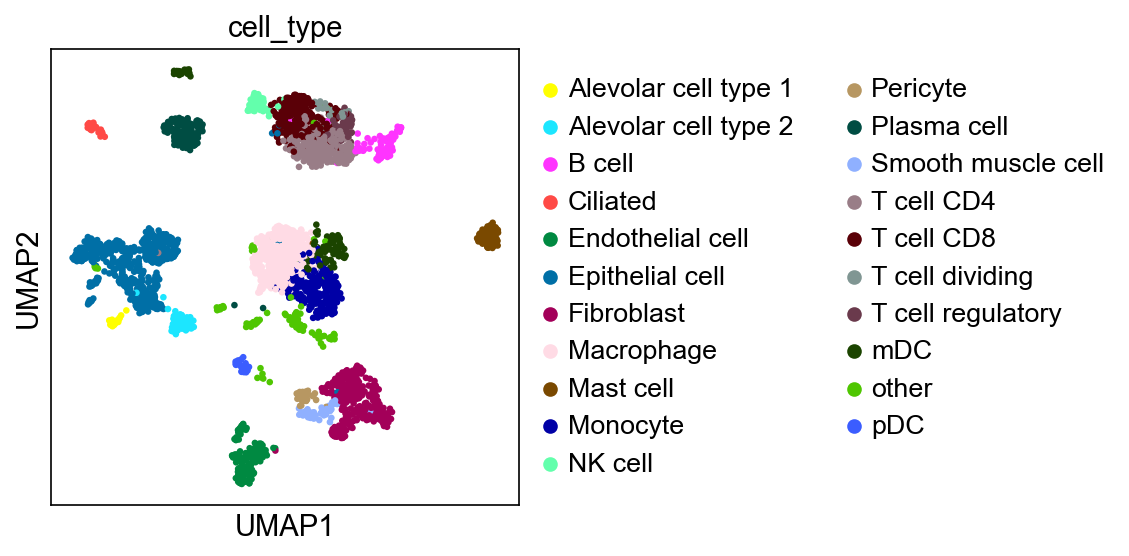

In [5]:
#Inspect UMAP plot based on the transcriptiomics data
sc.pl.umap(adata, color="cell_type")

## Run infercnv
Essentially, this method sorts genes by chromosome and genomic position and compares the average gene expression over genomic region to a reference. The original inferCNV method uses a window size of 100, but larger window sizes can make sense, depending on the number of genes in your dataset.

infercnv() adds a cell x genomic_region matrix to adata.obsm[“X_cnv”].

#### Note about choosing reference cells: 

The most common use-case is to compare tumor against normal cells. If you have prior information about which cells are normal (e.g. from cell-type annotations based on transcriptomics data), it is recommended to provide this information to infercnv().

The more different cell-types you can provide, the better. Some cell-types physiologicallly over-express certain genomic regions (e.g. plasma cells highly express Immunoglobulin genes which are genomically adjacent). If you provide multiple cell-types, only regions are considered being subject to CNV that are different from all provided cell-types.

If you don’t provide any reference, the mean of all cells is used instead, which may work well on datasets that contain enough tumor and normal cells.

In [6]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=[
        "B cell",
        "Macrophage",
        "Mast cell",
        "Monocyte",
        "NK cell",
        "Plasma cell",
        "T cell CD4",
        "T cell CD8",
        "T cell regulatory",
        "mDC",
        "pDC",
    ],
    window_size=250,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Can plot smoothed gene expression by cell-type and chromosome and observe that the Epithelial cell cluster, which consists largely of tumor cells, appears to be subject to copy number variation.

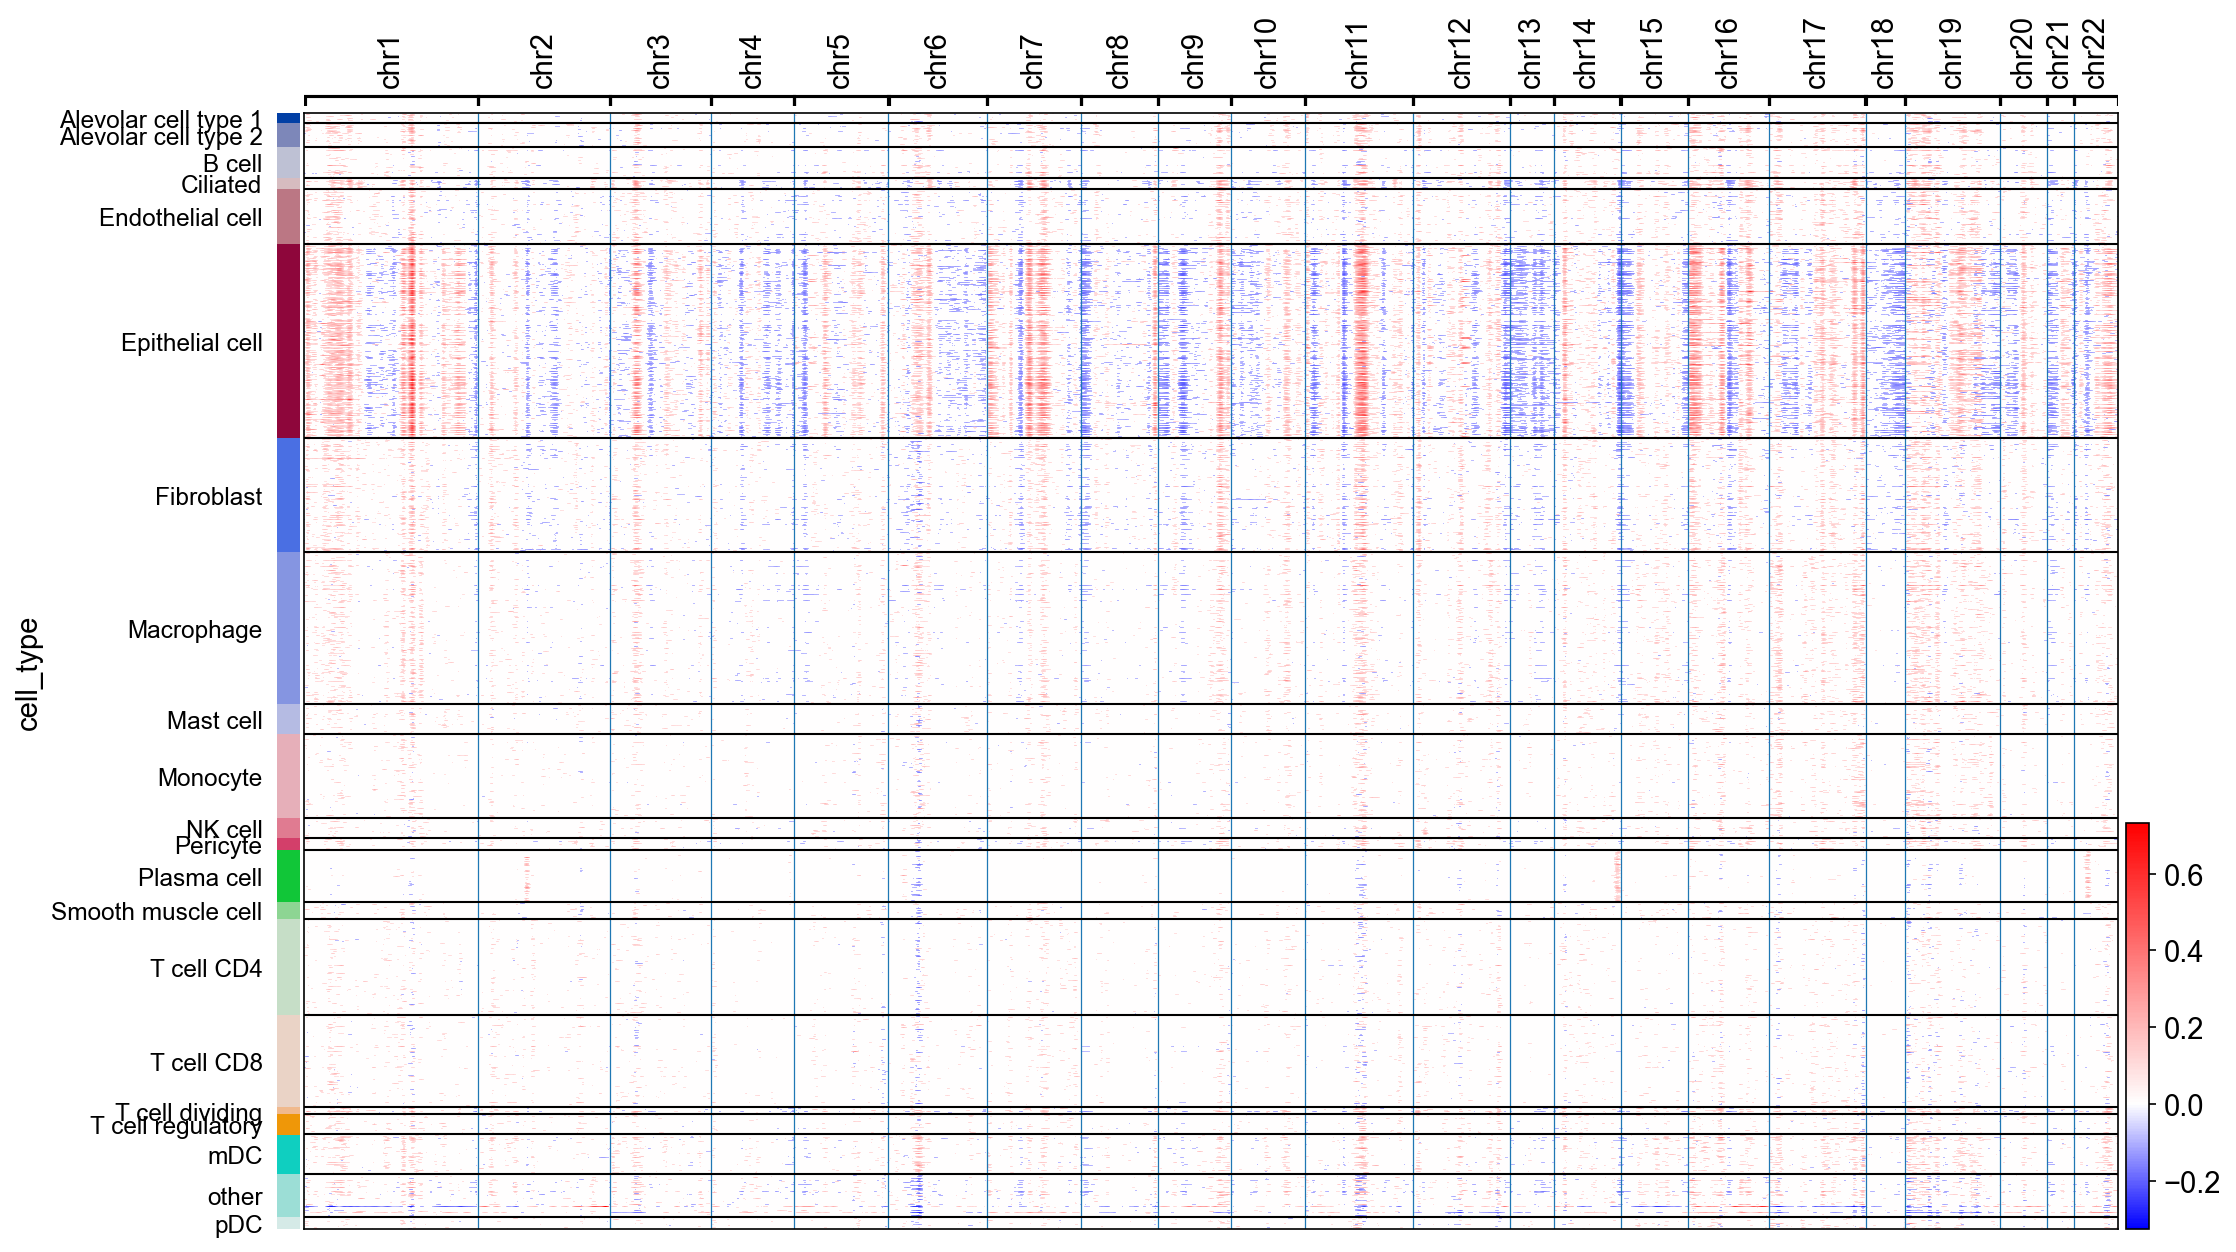

In [7]:
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

## Clustering by CNV profiles and identifying tumor cells

To cluster and annotate cells, infercnvpy mirrors the scanpy workflow, except that the functions (see below) use the CNV profile matrix as input. Using these functions, we can perform graph-based clustering and generate a UMAP plot based on the CNV profiles. Based on these clusters, we can annotate tumor and normal cells.
        
    infercnvpy.tl.pca, infercnvpy.pp.neighbors, infercnvpy.tl.leiden,
    infercnvpy.tl.umap, infercnvpy.pl.umap

In [8]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

After running leiden clustering, we can plot the chromosome heatmap by CNV clusters. We can observe that, as opposted to the clusters at the bottom, the clusters at the top have essentially no differentially expressed genomic regions. The differentially expressed regions are likely due to copy number variation and the respective clusters likely represent tumor cells.

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


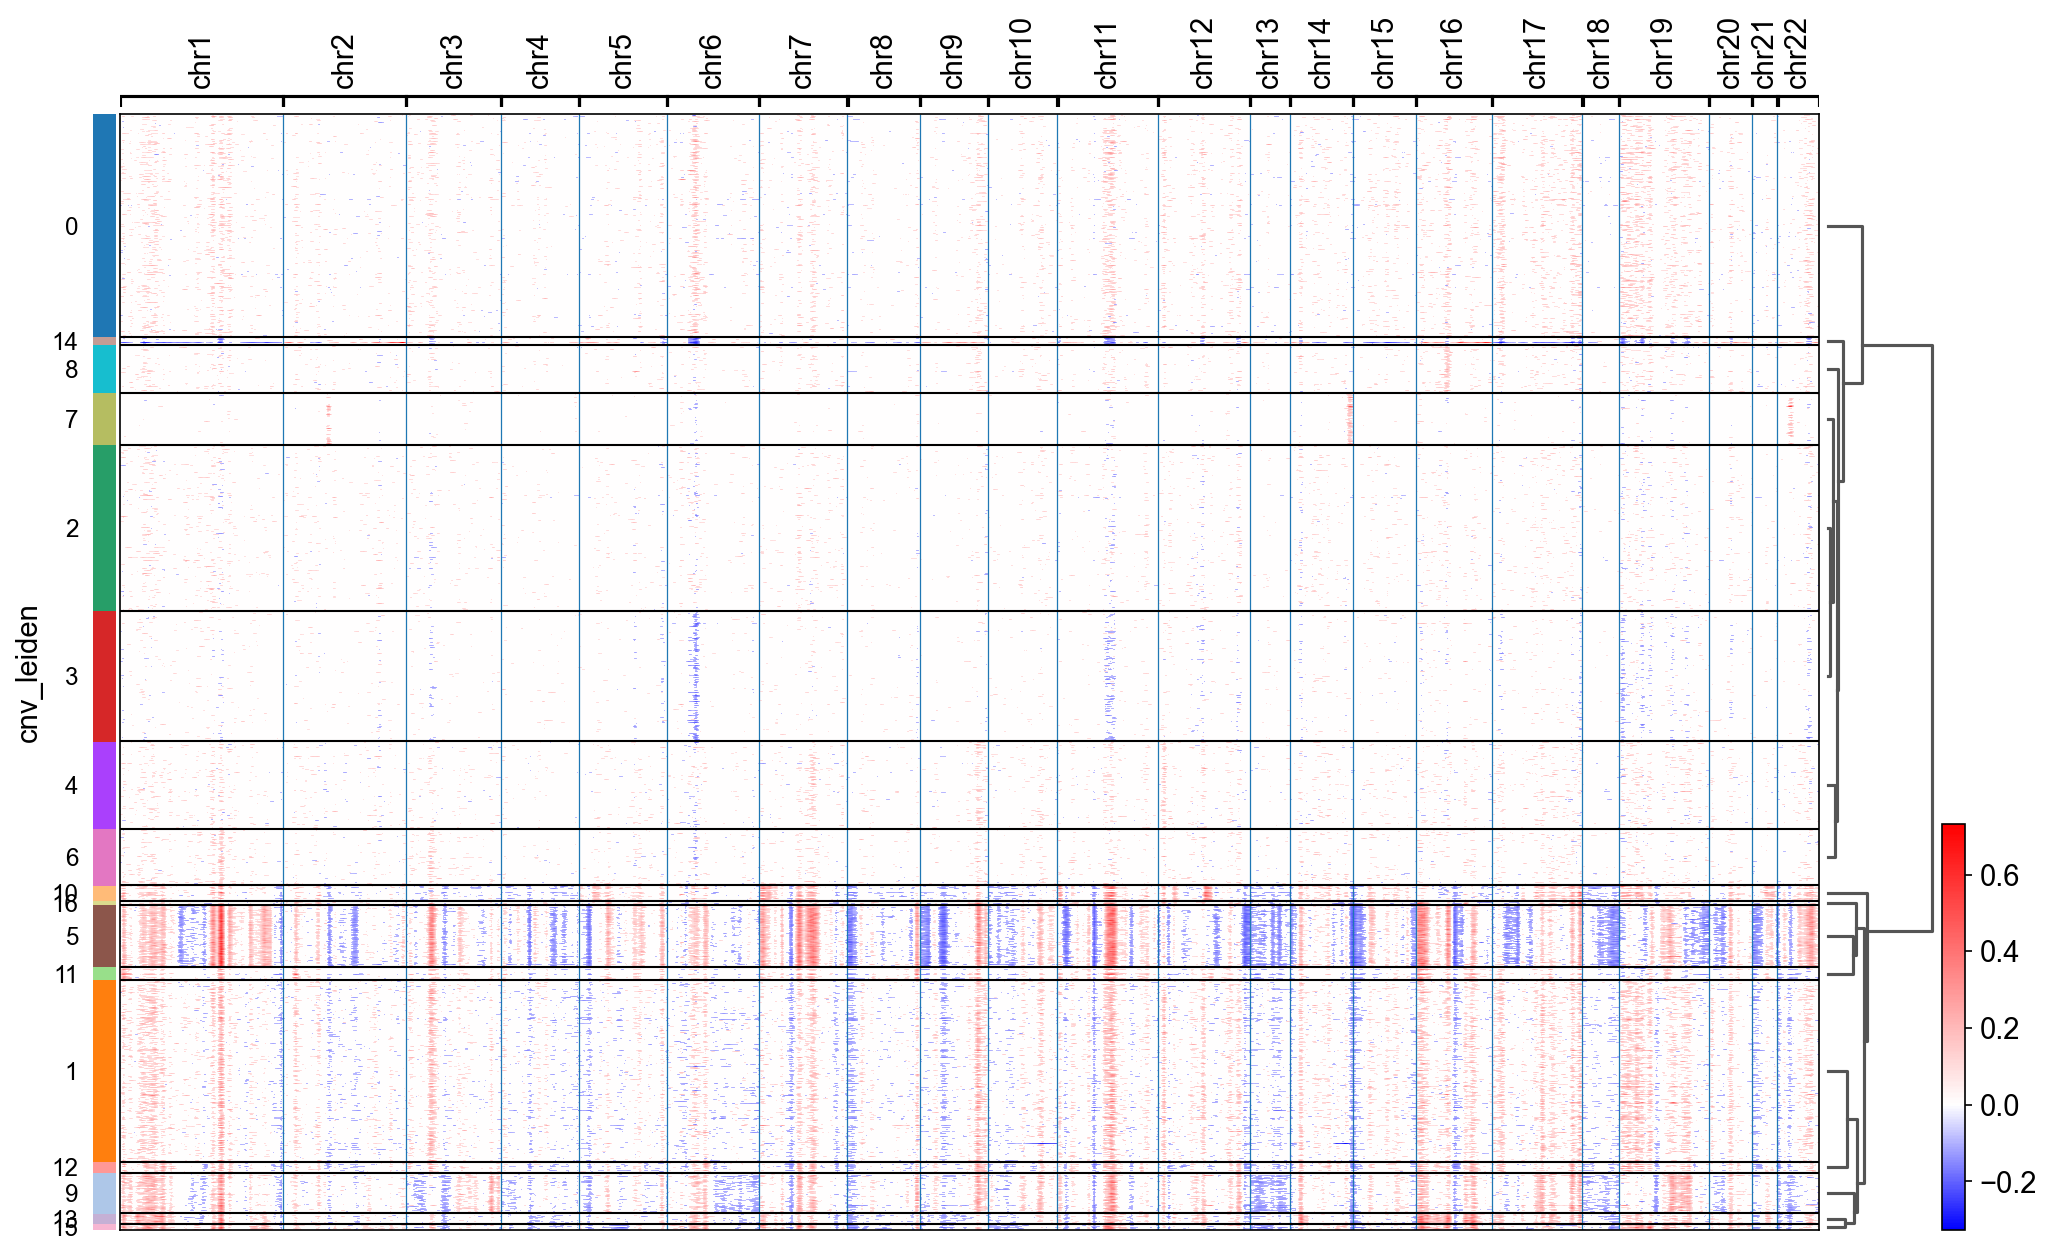

In [9]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

## UMAP plot of CNV profiles
We can visualize the same clusters as a UMAP plot. Additionally, infercnvpy.tl.cnv_score() computes a summary score that quantifies the amount of copy number variation per cluster. It is simply defined as the mean of the absolute values of the CNV matrix for each cluster.

In [10]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

The UMAP plot consists of a large blob of “normal” cells and several smaller clusters with distinct CNV profiles. Except for cluster “12”, which consists of ciliated cells, the isolated clusters are all epithelial cells. These are likely tumor cells and each cluster represents an individual sub-clone.

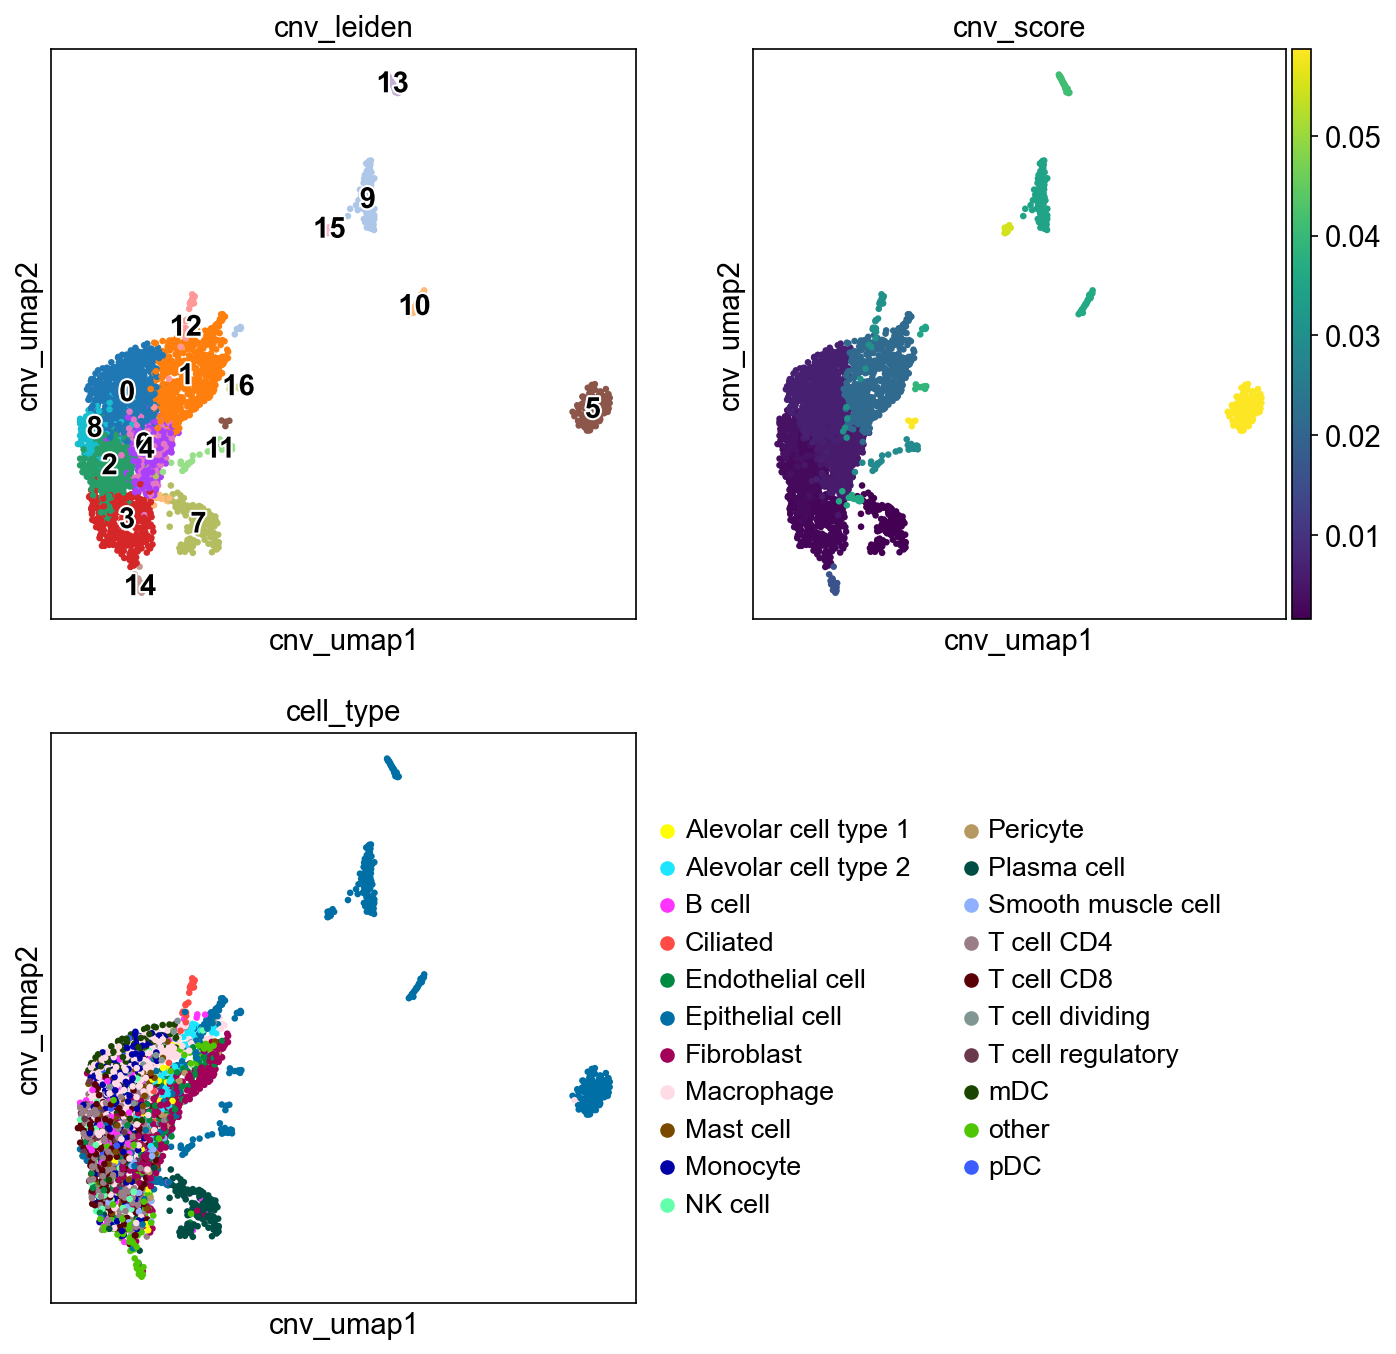

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

We can also visualize the CNV score and clusters on the transcriptomics-based UMAP plot. Again, we can see that there are subclusters of epithelial cells that belong to a distinct CNV cluster, and that these clusters tend to have the highest CNV score.

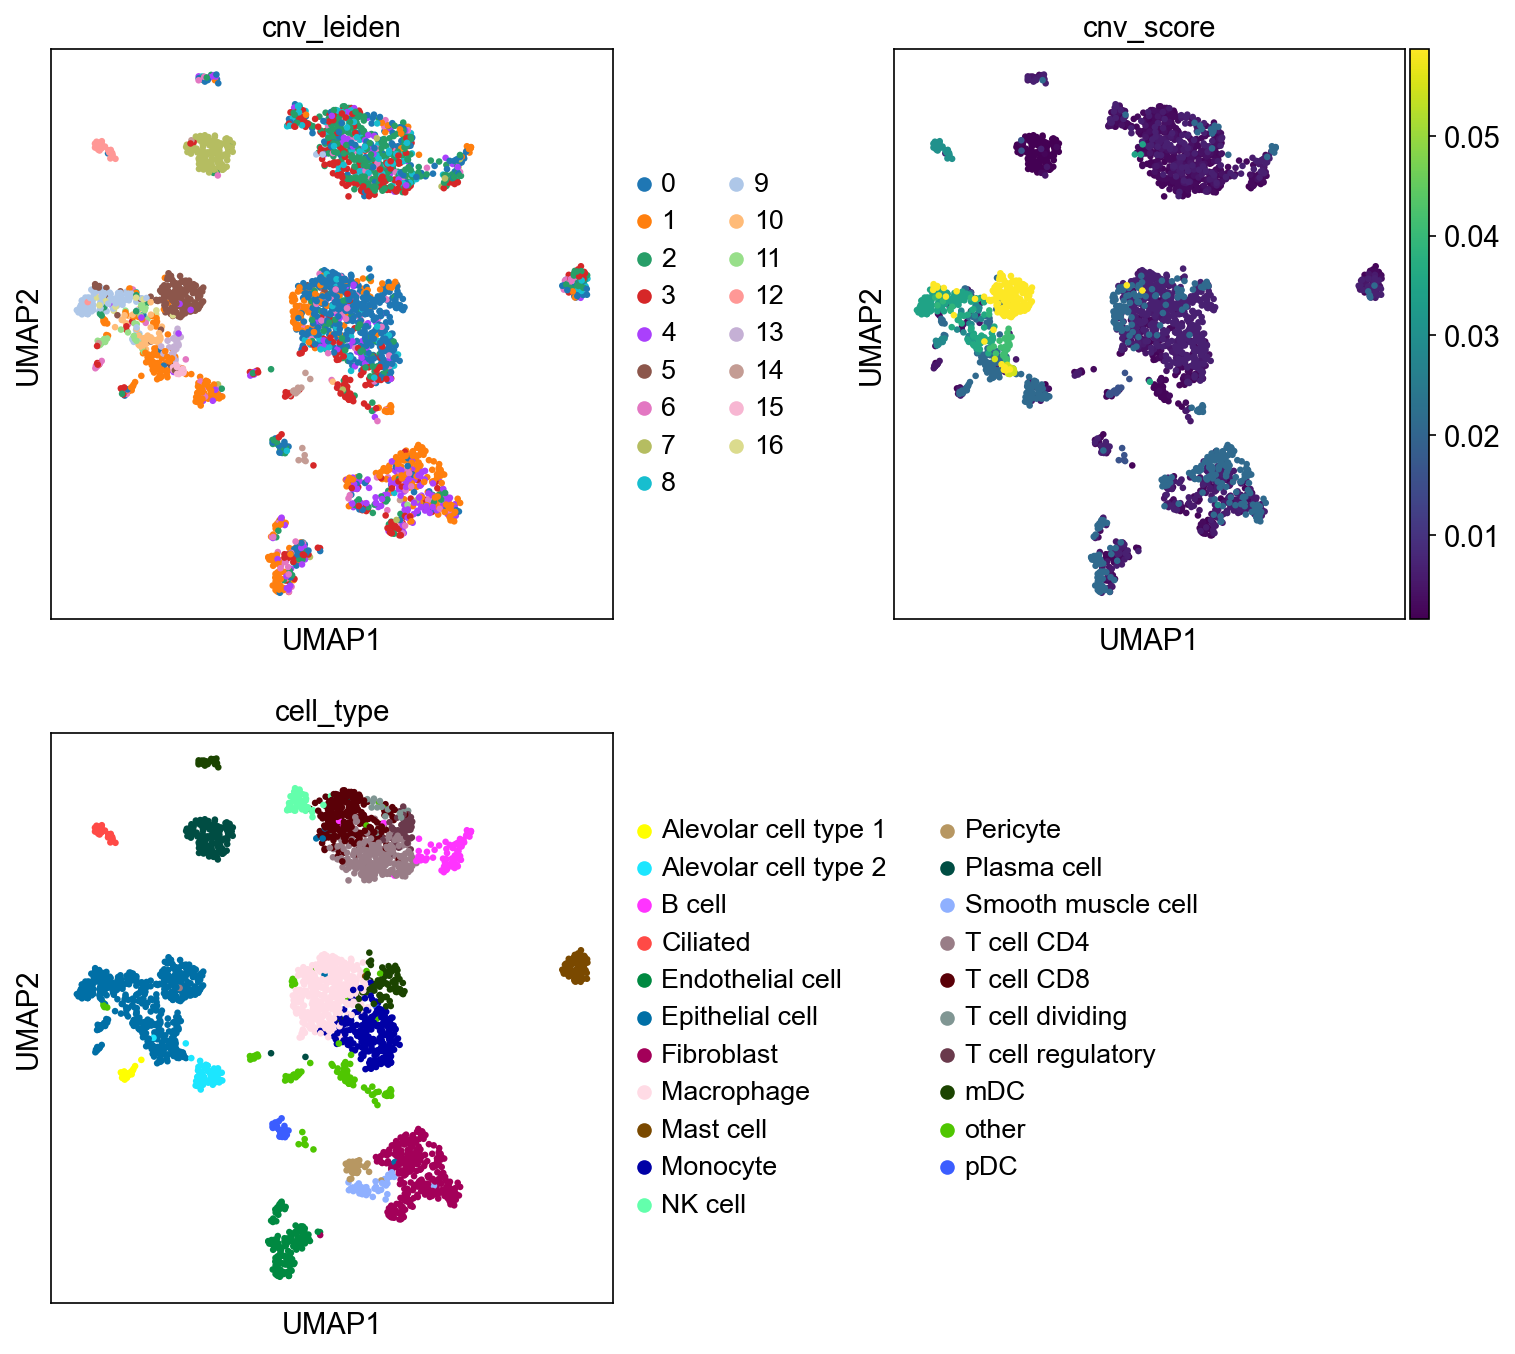

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

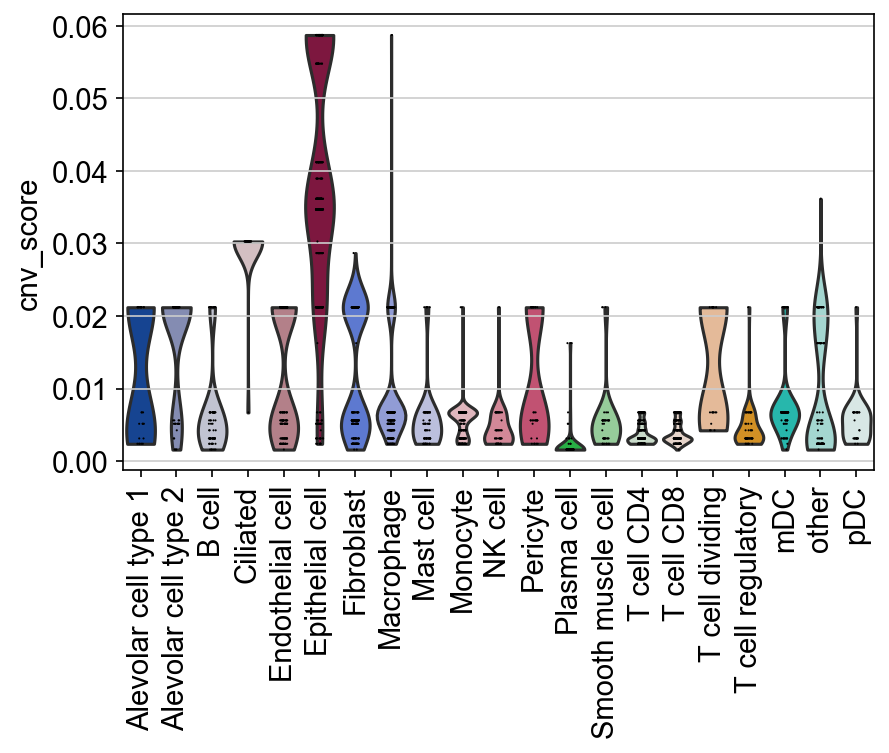

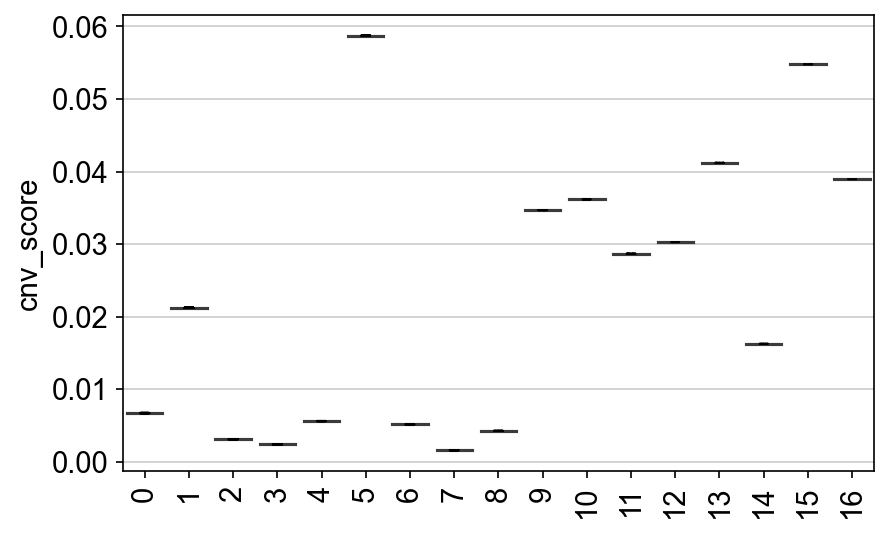

In [13]:
#can plot the cnv_score for each leiden cluster and cell type as well:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
sc.pl.violin(adata, 'cnv_score', groupby='cell_type', 
                  rotation=90)
sc.pl.violin(adata, 'cnv_score', groupby='cnv_leiden', 
                  rotation=90)

## Classifying tumor cells
Based on these observations, we can now assign cell to either “tumor” or “normal”. To this end, we add a new column cnv_status to adata.obs.

... storing 'cnv_status' as categorical


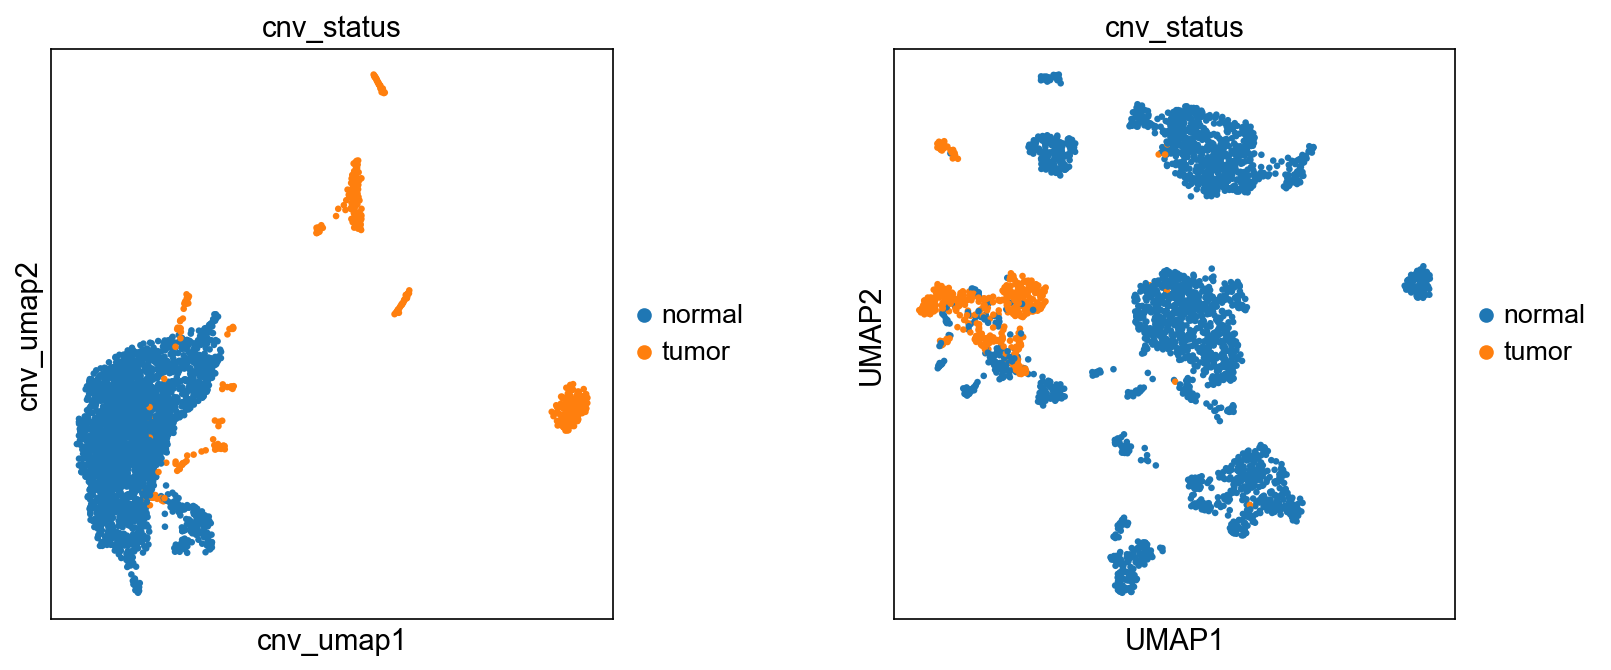

In [14]:
adata.obs["cnv_status"] = "normal"
adata.obs.loc[
    adata.obs["cnv_leiden"].isin(["9", "10", "13", "15", "5", "11", "16", "12"]), "cnv_status"
] = "tumor"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw=dict(wspace=0.5))
cnv.pl.umap(adata, color="cnv_status", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_status", ax=ax2)

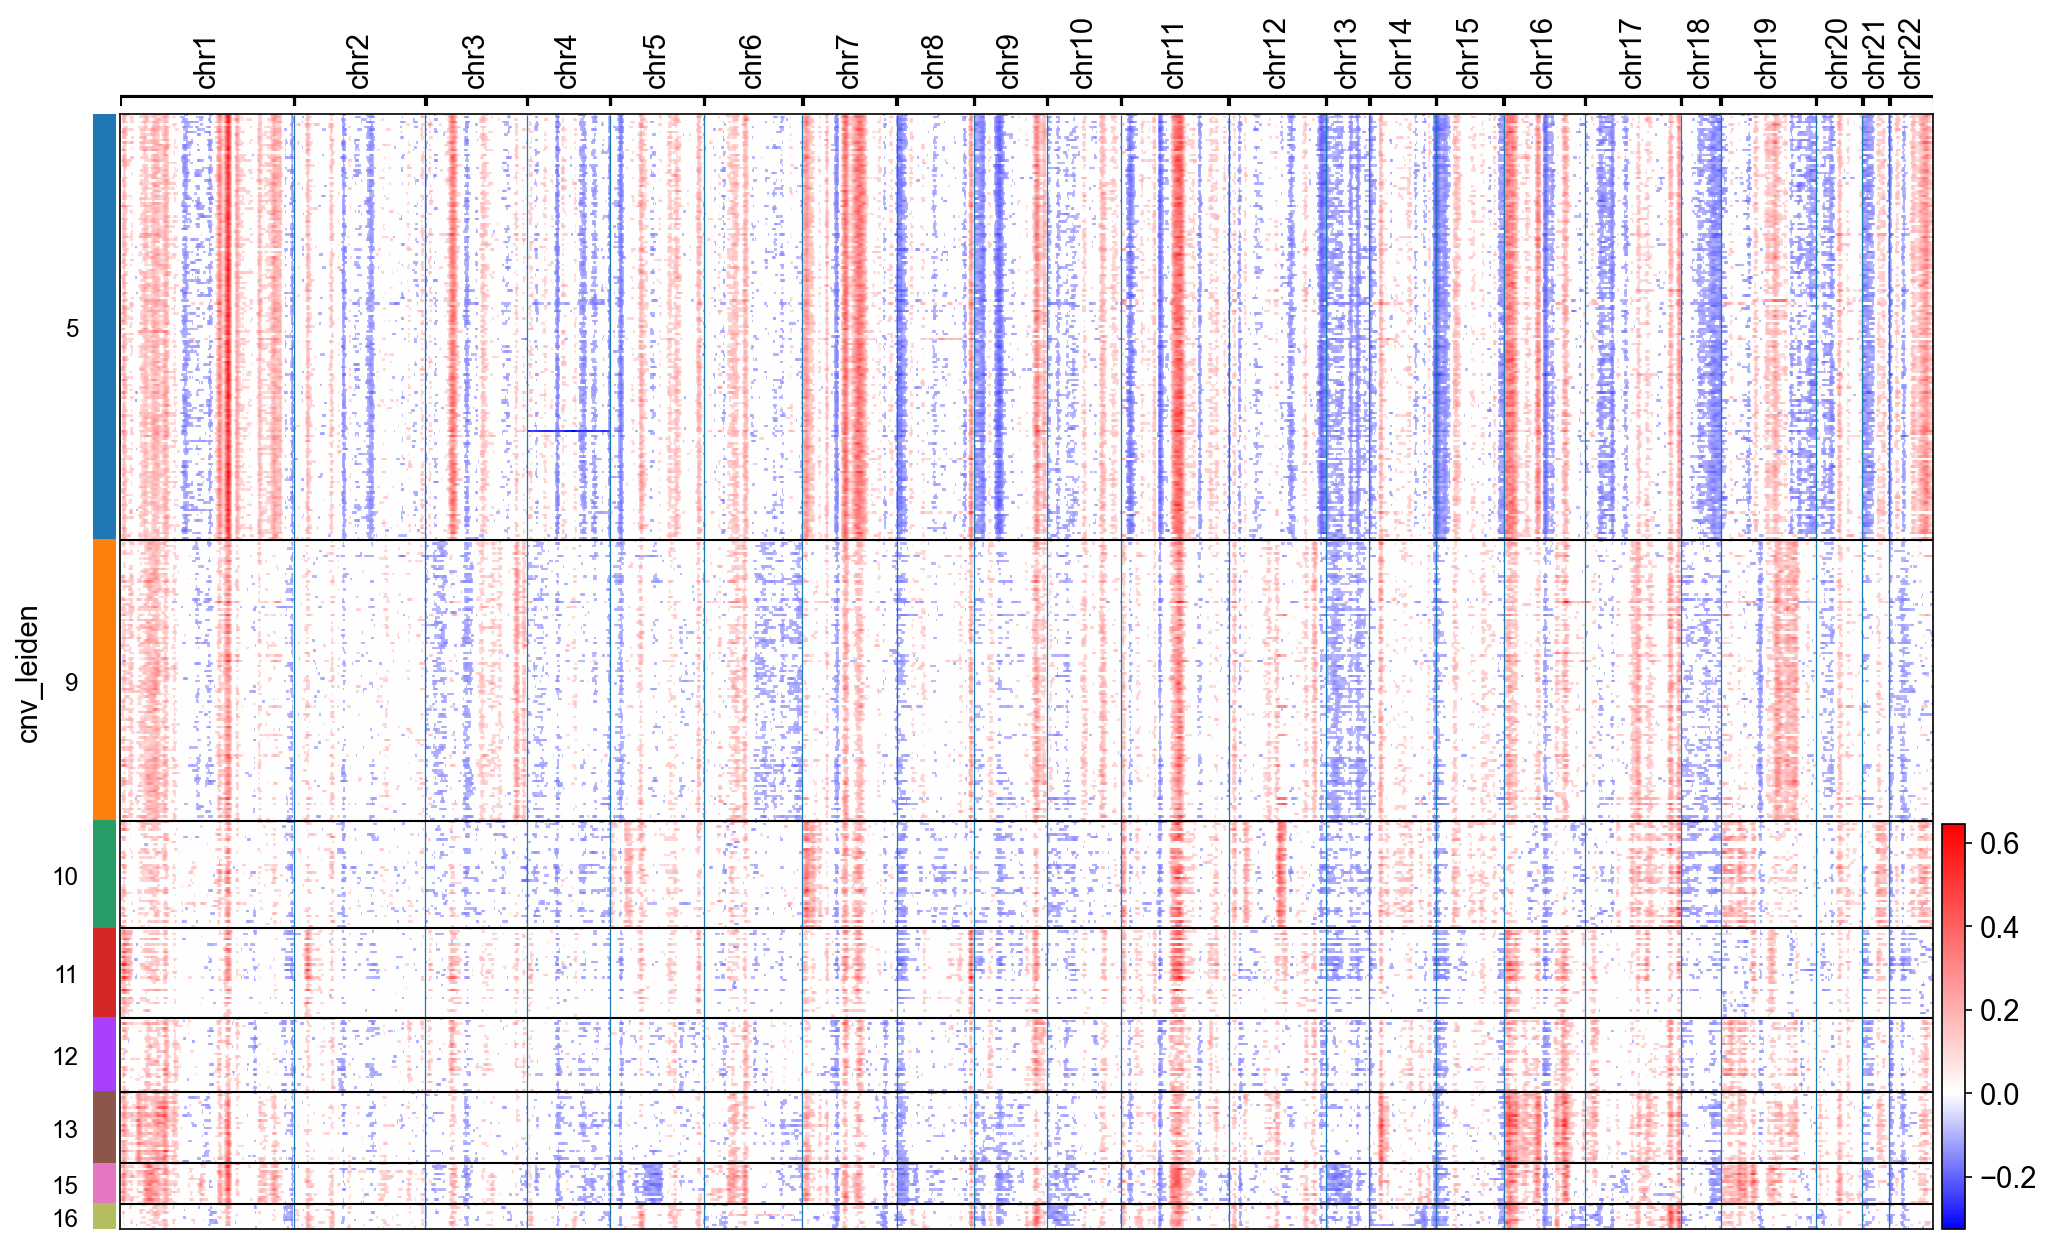

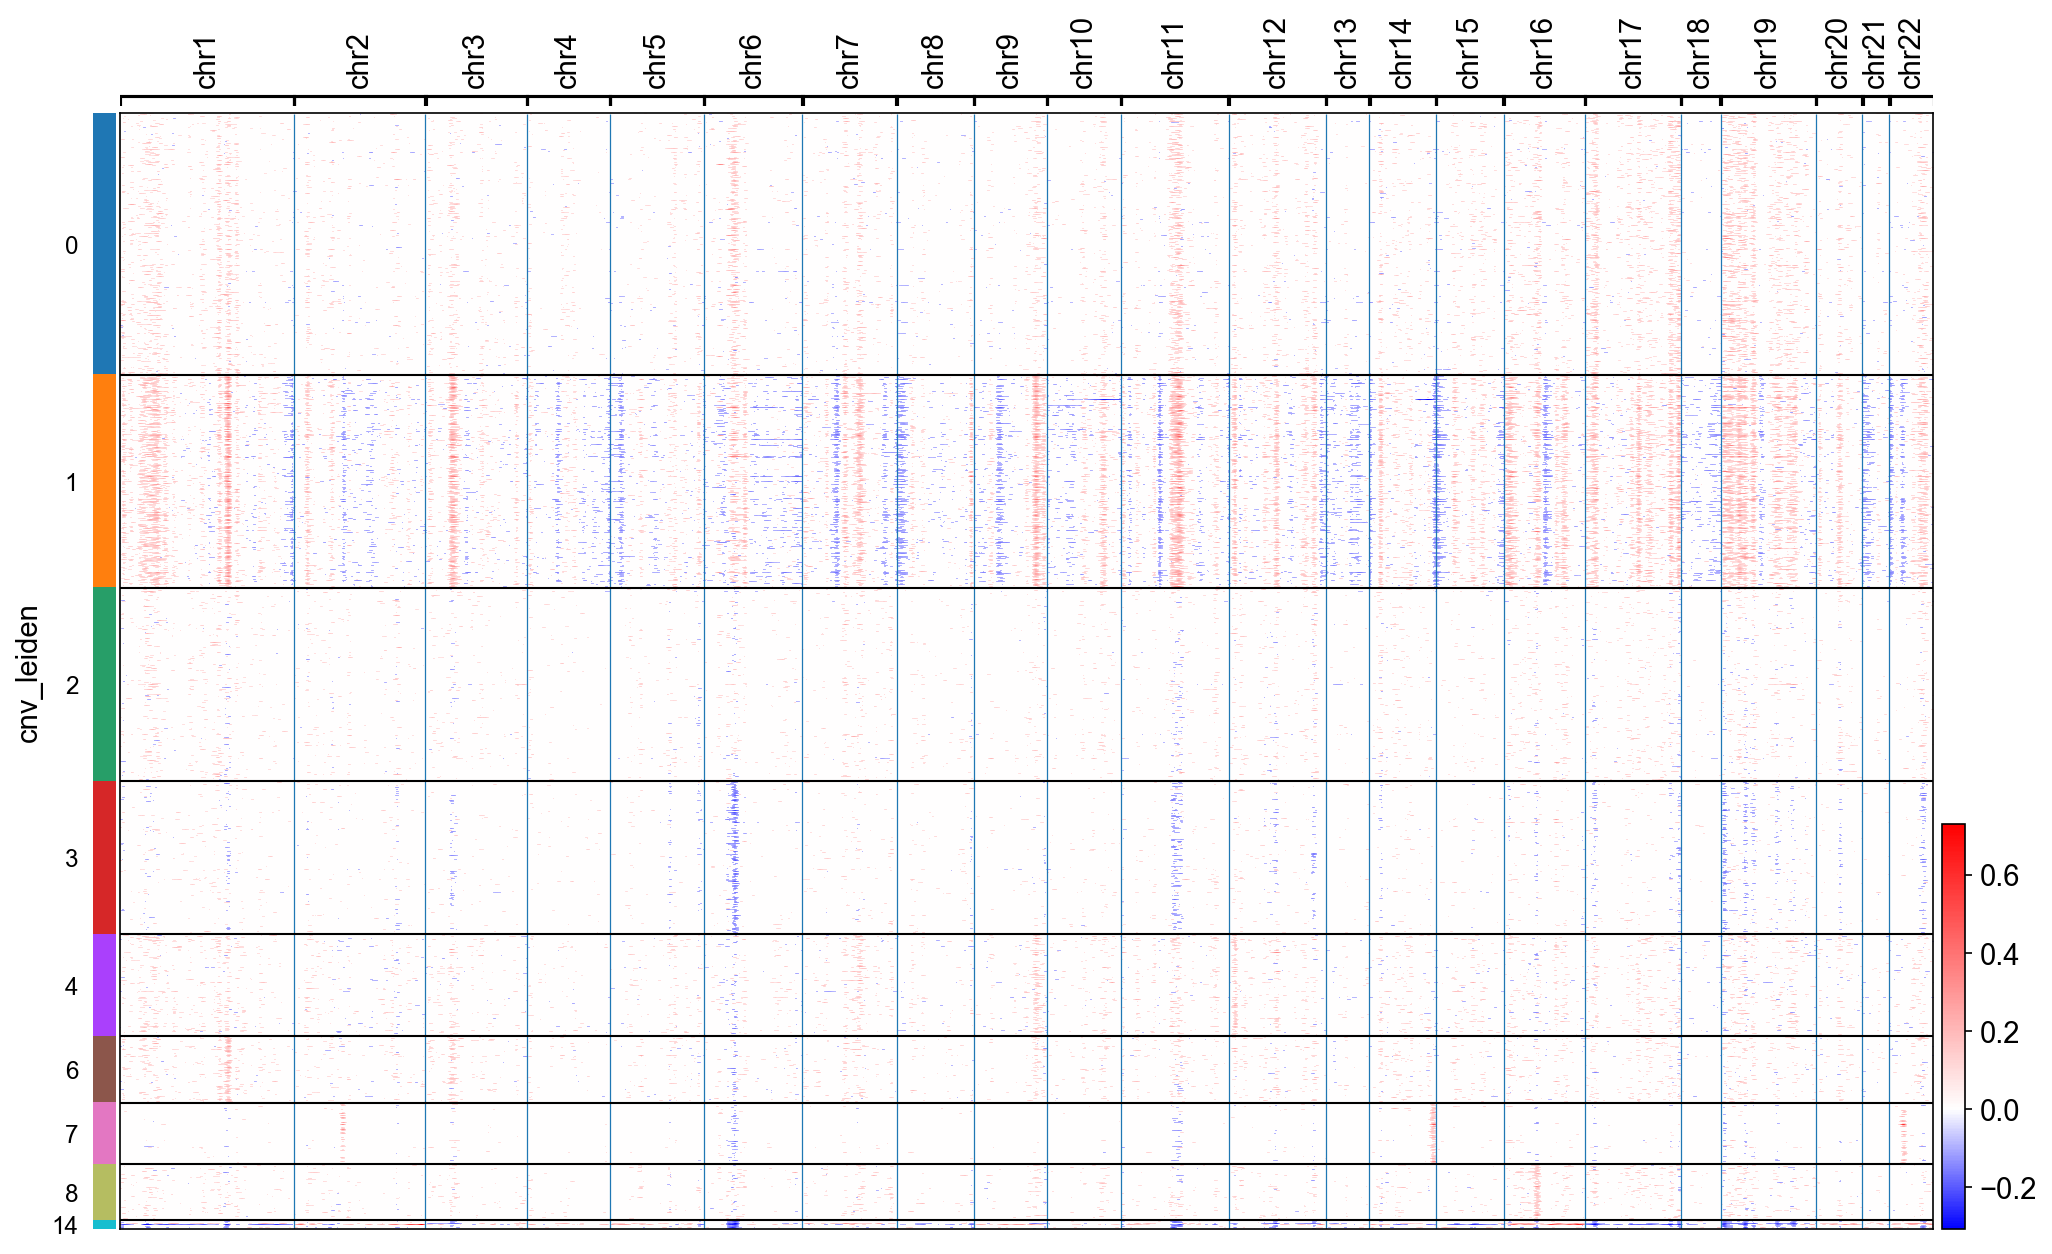

In [15]:
#Now, we can plot the CNV heatmap for tumor and normal cells separately:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "tumor", :])
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "normal", :])